In [1]:
import pandas as pd
import os
import tqdm
import numpy as np
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import string
import re
import nltk
import html
from bs4 import BeautifulSoup

/Users/alexkulbyakov/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
folder_path = 'sampled_texts_1'
texts_data = []

### Функция для считывания и обработки файлов.

-Приведение к нижнему регистру  
-Удаление лишних пробелов  
-Удаляются лишние спец.символы, ссылки, html теги и т.п., которые не несут смысловой нагрузки   
-Стоп-слова для sentence-transformers не удаляются, так как могут нести кажную информацию для семантического понимания  
-Тоенизация происходит внутри модели

In [4]:
def reading_documents(folder_path,data=[]):
    for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path,filename),'r') as file:
            lines = file.readlines()

            Topic = lines[0].replace('Topic:','').strip().lower()
            Text = lines[2].replace('Text:','').strip().lower()
            Topic_and_Text = Topic+'.'+Text
            
            #decode and remove html
            decoded_html = html.unescape(Topic_and_Text)
            soup = BeautifulSoup(decoded_html, "html.parser")
            clean_html = re.sub(r'<p>\s*</p>', '', str(soup))
            soup_cleaned = BeautifulSoup(clean_html, "html.parser")
            text_clean = soup_cleaned.get_text()
            
            #remove simbols
            text_clean = re.sub(r'[^A-Za-z0-9.,!?;:\-\'\"\s]+', '', text_clean)
            
            data.append(text_clean)
    return data

In [5]:
texts = reading_documents(folder_path,texts_data)
texts

/var/folders/nt/741dhj3j3sz99f4rylg99x8c0000gn/T/ipykernel_2194/3257315889.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(decoded_html, "html.parser")
/var/folders/nt/741dhj3j3sz99f4rylg99x8c0000gn/T/ipykernel_2194/3257315889.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup_cleaned = BeautifulSoup(clean_html, "html.parser")


['bentley comes home just ahead of ne-10 crowd.the northeast-10 conference race is entering the final third of the season, and the four teams atop the standings are separated by just a half-game.',
 'ft gets collins stewart claim struck out.the financial times today won its action to strike out a record 230.5m libel damages claim from city brokers collins stewart that could have closed down the pink paper.',
 'u.s. groups accuse china of failing to stop intellectual property abuses canadian press.canadian press - beijing ap - adding to pressure for china to stop rampant product piracy, two major u.s. business groups complained thursday that abuses are getting worse and warned that lack of patent and copyright protection is hurting high-tech investment.',
 "team as we know it is history.the news comes fast and furious. pedro martinez goes to tampa to visit george steinbrenner. theo epstein and john henry go to florida for their turn with pedro. carl pavano comes to boston to visit curt 

### Функция для составления эмбеддингов

In [6]:
def conversion_to_embeddings(data):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    document_embedding = list()

    for i in range(len(data)):
        document_embedding.append(model.encode(data[i]))
    return document_embedding
# import numpy as np
# document_embedding = np.squeeze(document_embedding)

In [7]:
texts_embeddings = conversion_to_embeddings(texts)

/Users/alexkulbyakov/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:
def elbow_method(embeddings):
    Inertia = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init=8)
        kmeans.fit(embeddings)
        Inertia.append(kmeans.inertia_)

    plt.plot(K, Inertia, 'x-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Inertia')
    plt.title('Метод локтя')
    plt.show()

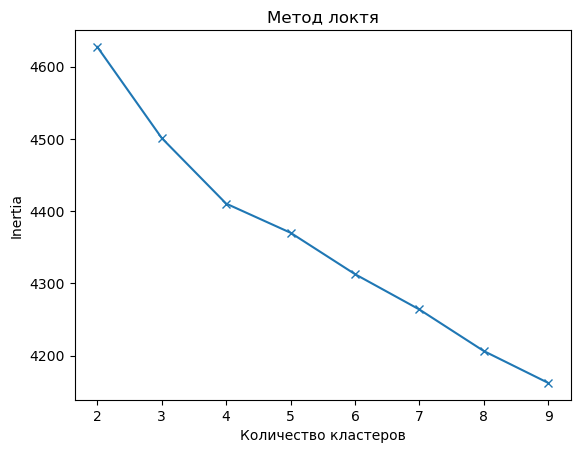

In [45]:
elbow_method(texts_embeddings);

In [32]:
def silhouette_analysis(embeddings):
    silhouette_scores = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k,n_init=8)
        kmeans.fit(embeddings)
        score = silhouette_score(embeddings, kmeans.labels_)
        silhouette_scores.append(score)

    plt.plot(K, silhouette_scores, 'x-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    plt.show()

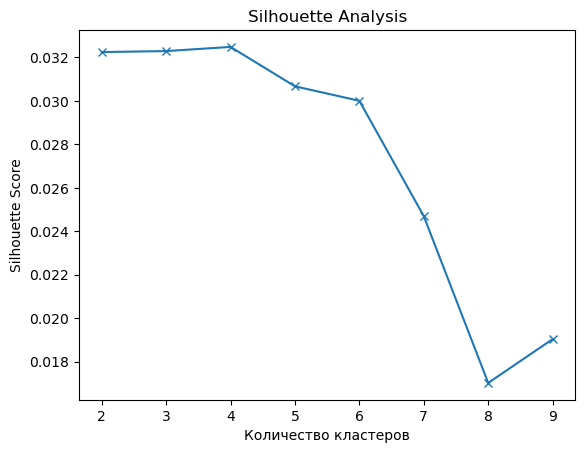

In [33]:
silhouette_analysis(texts_embeddings);

С помощью метода локтя видно, что на после 4 снижение становится менее значительным.   
С помощью силуетного анализа видно, что в точке 4 достигается максимум силует скора.  
Так что опираясь на метод локтя и силуетный анализ:  

Число кластеров 4

In [46]:
kmeans_model = KMeans(n_clusters=4, n_init=8)
kmeans_model.fit(texts_embeddings)

KMeans(n_clusters=4, n_init=8)

In [47]:
cluster_labels_final = kmeans_model.labels_ 
cluster_labels_final

array([2, 3, 1, 2, 3, 0, 2, 2, 3, 0, 1, 0, 2, 2, 0, 3, 1, 3, 1, 3, 3, 3,
       3, 0, 2, 3, 3, 2, 2, 3, 0, 3, 1, 3, 2, 0, 1, 2, 0, 2, 3, 3, 2, 3,
       2, 0, 3, 1, 3, 3, 3, 3, 1, 3, 0, 0, 3, 3, 1, 3, 1, 3, 0, 2, 3, 2,
       2, 2, 0, 3, 3, 3, 3, 3, 0, 1, 1, 1, 3, 0, 3, 2, 0, 2, 3, 3, 3, 3,
       2, 0, 2, 3, 3, 3, 3, 0, 3, 3, 0, 1, 3, 0, 3, 1, 0, 2, 2, 0, 3, 3,
       1, 1, 3, 3, 1, 2, 3, 1, 3, 2, 2, 3, 2, 2, 3, 1, 0, 2, 3, 3, 3, 3,
       2, 3, 3, 3, 0, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 2, 0, 3, 3, 3, 0, 0,
       2, 3, 1, 1, 3, 3, 2, 2, 2, 1, 0, 3, 3, 3, 1, 2, 0, 3, 3, 3, 1, 1,
       2, 0, 1, 1, 3, 0, 2, 2, 3, 3, 2, 1, 3, 0, 1, 2, 2, 3, 3, 1, 3, 3,
       1], dtype=int32)

## Новый документ

In [48]:
new_doc_data = []
new_folder = 'new_documents'

In [49]:
new_document = reading_documents(new_folder,new_doc_data)
new_document

["rebels return to 'cleared' areas.in fallujah, us forces are going through 50,000 houses one by one. but insurgents are coming back in the morning."]

In [50]:
new_embedding = conversion_to_embeddings(new_document)

/Users/alexkulbyakov/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [51]:
nbrs = NearestNeighbors(n_neighbors=1, metric='cosine').fit(texts_embeddings)
distances, indices = nbrs.kneighbors(new_embedding)

In [52]:
nearest_document_index = indices[0][0]
assigned_cluster = cluster_labels_final[nearest_document_index]

In [53]:
assigned_cluster

0